In [2]:
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
import shapefile
import osr
import dbf
import requests
import io
import datetime

from urllib.request import urlopen
from zipfile import ZipFile
from shapely.geometry import shape, Point, Polygon


%matplotlib inline

In [3]:
countypairs = pd.read_csv('/home/jinli/PycharmProjects/county-pair-list.txt')
countypairs.drop_duplicates(subset='COUNTYPAIR_ID', inplace = True)

new = countypairs['COUNTYPAIR_ID'].str.split("-", n = 1, expand = True)

pairid = pd.concat([new[0], new[1]], ignore_index=True)
pairid = pairid.drop_duplicates()
pairid = pairid.to_frame('id')
pairid = pairid[~pairid['id'].isin(['06001', '06041', '06081','06075'])] ### county fips changed

### LAUS data (Unemployment Rate)

In [7]:
files = glob.glob('/home/jinli/Desktop/Thesis/Data/LAU(unemployment_rate)/*.csv')
dfs = [pd.read_csv(file) for file in files]
lausdata = pd.concat(dfs, ignore_index=True)

lausdata['GEOID10'] = lausdata['Series ID'].map(lambda x: x[5:10])
lausdata['STATEFP10'] = lausdata['GEOID10'].map(lambda x: x[0:2])
lausdata['COUNTYFP10'] = lausdata['GEOID10'].map(lambda x: x[2:])

lausdata = pd.merge(pairid, lausdata, how='left', left_on='id', right_on='GEOID10')
lausdata = lausdata.dropna()
### a = lausdata.GEOID10.unique()
### len(a)      1126

In [ ]:
lausdata.to_csv('LAUS_COUNTY_MONTHLY_UNEMPLOYMENT.csv', index=False)

### Transform monthly LAUS data to quarterly data

In [8]:
mlaus = pd.read_csv('LAUS_COUNTY_MONTHLY_UNEMPLOYMENT.csv')

mlaus['id'] = mlaus['id'].astype(str)
mlaus['id'] = mlaus['id'].str.zfill(5)

mlaus['Year'] = mlaus['Year'].astype(int)
mlaus = mlaus[(mlaus['Year'] > 2005) & (mlaus['Year'] < 2016)]

mlaus['Value'] = pd.to_numeric(mlaus['Value'], errors='coerce')
mlaus = mlaus.replace(np.nan, 0, regex=True)

mlaus['Month'] = mlaus['Period'].str[1:]
mlaus['Year-Month'] = pd.to_datetime(mlaus[['Year', 'Month']].assign(Day=1)).dt.to_period('M')
mlaus['Qtr'] = pd.to_datetime(mlaus[['Year', 'Month']].assign(Day=1)).dt.quarter

mlaus = mlaus[['id', 'Year', 'Qtr', 'Value']]
mlaus.sort_values(by =['id', 'Year', 'Qtr'], ignore_index=True, inplace=True)

qlaus = mlaus.groupby(['id', 'Year', 'Qtr'])['Value'].mean().reset_index()

/home/jinli/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
qlaus.to_csv('LAUS_COUNTY_QUARTERLY_UNEMPLOYMENT.csv', index=False)

### GeoPlot: all states, all counties and broder counties

In [4]:
## All counties
allcounties = ZipFile('/home/jinli/PycharmProjects/tl_2010_us_county10(NEW).zip', 'r')

filenames_ac = [y for y in sorted(allcounties.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_ac, prj_ac, shp_ac, shx_ac = [io.BytesIO(allcounties.read(filename)) for filename in filenames_ac]

r_ac = shapefile.Reader(shp=shp_ac, shx=shx_ac, dbf=dbf_ac)
## r_ac.numRecords   ### 3221


attributes, geometry = [], []

field_names = [field[0] for field in r_ac.fields[1:]]

for row in r_ac.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_ac, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_ac = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf_ac.sort_values(by =['STATEFP10', 'COUNTYFP10'], inplace=True)
gdf_ac.reset_index(drop=True, inplace=True)
gdf_ac[['INTPTLON10', 'INTPTLAT10']] = gdf_ac[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)

gdf_ac = gdf_ac[(gdf_ac.STATEFP10 != '02') & (gdf_ac.STATEFP10 != '72') & (gdf_ac.STATEFP10 != '15')]

In [5]:
## All states
allstates = ZipFile('/home/jinli/PycharmProjects/tl_2010_us_state10.zip', 'r')

filenames_as = [y for y in sorted(allstates.namelist())
                for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_as, prj_as, shp_as, shx_as = [io.BytesIO(allstates.read(filename)) for filename in filenames_as]

r_as = shapefile.Reader(shp=shp_as, shx=shx_as, dbf=dbf_as)

attributes, geometry = [], []

field_names = [field[0] for field in r_as.fields[1:]]
for row in r_as.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_as, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_as = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf_as = gdf_as[~gdf_as['STATEFP10'].isin(['02', '72', '15'])]
gdf_as.sort_values(by ='STATEFP10', ignore_index=True, inplace=True)

In [9]:
cp_list = lausdata.GEOID10.tolist()
cp_list = list(set(cp_list)) ## remove duplicates
cp_list = [e for e in cp_list if e not in ('06001', '06041', '06081','06075')]

In [ ]:
len(cp_list)

In [ ]:
cp_list

In [10]:
gdf_cp = gdf_ac[gdf_ac['GEOID10'].isin(cp_list)]

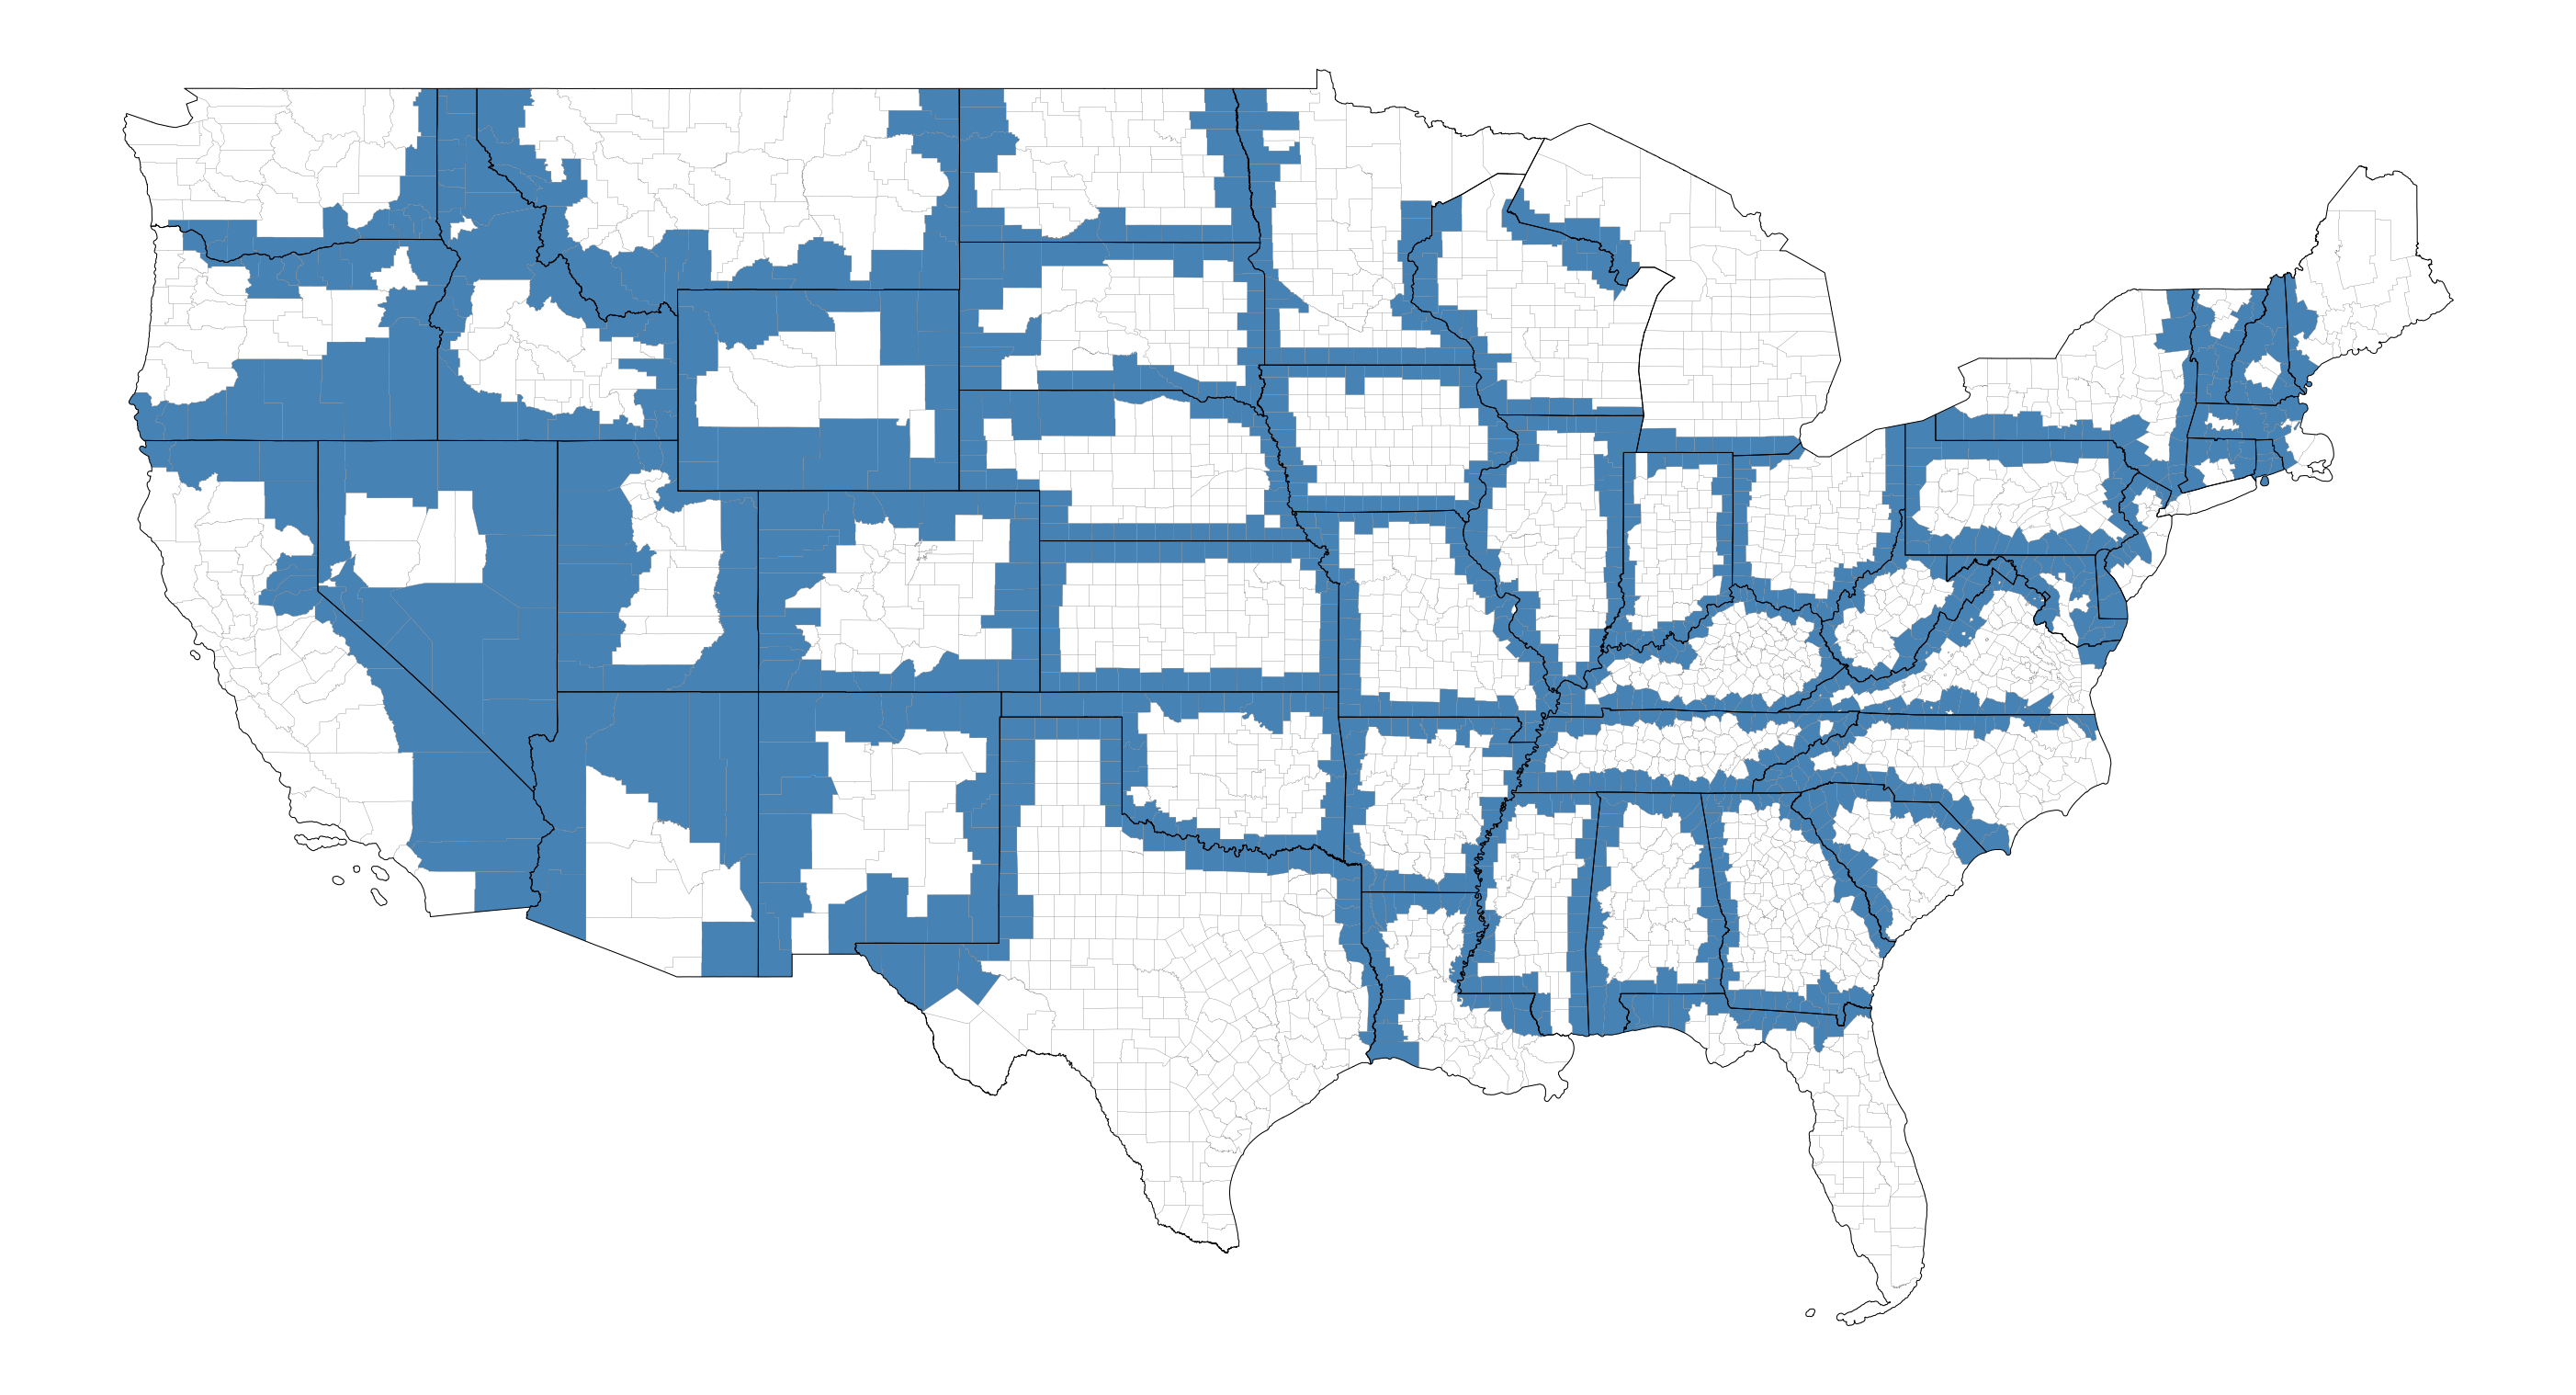

In [11]:
fig, ax = plt.subplots(figsize=(50,50))
gdf_cp.plot(ax=ax, color='steelblue', edgecolor='none')
gdf_ac.plot(ax=ax, facecolor='none', linewidth=0.2, edgecolor='grey')
gdf_as.plot(ax=ax, facecolor='none', linewidth=1, edgecolor='black')
ax.axis('off')
fig.savefig('full_figure.png')

In [ ]:
gdf_as.head()

## State-level maximum benefit duration

In [12]:
state_geo = gdf_as[['GEOID10', 'NAME10', 'geometry']]

In [13]:
benefits = pd.read_csv('Maximum_Benefit_Duration.csv')

width = 2
benefits["state_id"]= benefits["state_id"].astype(str) 
benefits["state_id"]= benefits["state_id"].str.zfill(width) 

In [14]:
benefits08q4 = benefits[benefits.variable == '2008Q4']
benefits09q4 = benefits[benefits.variable == '2009Q4']
benefits11q4 = benefits[benefits.variable == '2011Q4']
benefits12q4 = benefits[benefits.variable == '2012Q4']

In [15]:
df08q4 = pd.merge(state_geo, benefits08q4, how='left', left_on='GEOID10', right_on='state_id')
df09q4 = pd.merge(state_geo, benefits09q4, how='left', left_on='GEOID10', right_on='state_id')
df11q4 = pd.merge(state_geo, benefits11q4, how='left', left_on='GEOID10', right_on='state_id')
df12q4 = pd.merge(state_geo, benefits12q4, how='left', left_on='GEOID10', right_on='state_id')

In [16]:
df08q4 = df08q4[['GEOID10', 'NAME10', 'value', 'geometry']]
df09q4 = df09q4[['GEOID10', 'NAME10', 'value', 'geometry']]
df11q4 = df11q4[['GEOID10', 'NAME10', 'value', 'geometry']]
df12q4 = df12q4[['GEOID10', 'NAME10', 'value', 'geometry']]

In [ ]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'value'
# set the range for the choropleth
vmin, vmax = 26, 99
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
df08q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('state-level maximum benefit duration in 2008Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})


fig.savefig('2008Q4_max_benefit.png', dpi=300)

In [ ]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'value'
# set the range for the choropleth
vmin, vmax = 26, 99
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
df09q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('state-level maximum benefit duration in 2009Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})


fig.savefig('2009Q4_max_benefit.png', dpi=300)

In [ ]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'value'
# set the range for the choropleth
vmin, vmax = 26, 99
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
df11q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('state-level maximum benefit duration in 2011Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})


fig.savefig('2011Q4_max_benefit.png', dpi=300)

In [ ]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'value'
# set the range for the choropleth
vmin, vmax = 26, 99
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
df12q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('state-level maximum benefit duration in 2012Q4 ', fontdict={'fontsize': '12', 'fontweight' : '1'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, orientation='horizontal')

fig.savefig('2012Q4_max_benefit.png', dpi=300)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)

# set a variable that will call whatever column we want to visualise on the map
variable = 'value'
# set the range for the choropleth
vmin, vmax = 26, 99
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
df08q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('state-level maximum benefit duration in 2008Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})


fig.savefig('2008Q4_max_benefit.png', dpi=300)

### QCEW (Quarterly Census of Employment and Wages)

In [ ]:
ids = pd.read_csv('Paired_County_ID.csv')
ids['id'] = ids['id'].astype(str)
ids['id'] = ids['id'].str.zfill(5)

In [ ]:
files = glob.glob('/home/jinli/Desktop/Thesis/Data/QCEW/2005.q1-q4.by_area/*.csv')
dfs = [pd.read_csv(file) for file in files]
qcewdata = pd.concat(dfs, ignore_index=True)

In [ ]:
qcewdata05 = qcewdata[qcewdata['area_fips'].apply(lambda x: str(x).isdigit())] 

In [ ]:
qcewdata05['area_fips'] = qcewdata05['area_fips'].astype(str)
qcewdata05['area_fips'] = qcewdata05['area_fips'].str.zfill(5)

In [ ]:
qcewdata05 = pd.merge(qcewdata05, ids, how='left', left_on='area_fips', right_on='id')

In [ ]:
df01001 = pd.read_csv('/home/jinli/Desktop/Thesis/Data/QCEW/2005.q1-q4.by_area/2005.q1-q4 01001 Autauga County, Alabama.csv')
df01001['area_fips'] = df01001['area_fips'].astype(str)
df01001['area_fips'] = df01001['area_fips'].str.zfill(5)
df01001.drop(df01001.columns[21:], axis=1, inplace=True)
df01001 = df01001.loc[df01001['own_code']==0]

In [ ]:
df01001

### Maximum Benefit Extension

In [ ]:
mbe = pd.read_excel('MaxBenefitExtension.xlsx', index_col=0) 

mbe.drop(columns=['2016Q1', '2016Q2', '2016Q3', '2016Q4'], inplace=True)
mbe.reset_index(inplace=True)
mbe = mbe.iloc[:, 2:]

mbe = mbe.melt(id_vars=['state_id'], ignore_index=True)
mbe.fillna(0, inplace=True) 
mbe['value'] += 26

In [ ]:
mbe.to_csv('Maximum_Benefit_Duration.csv', index=False)

## Data Merging

#### Step 1:  county-pair ids and centroid distances

In [ ]:
cp_dist = pd.read_csv('CountyPair_Centroid_Border_Distance.csv') ### 1178 entries
cp_id = pd.read_csv('Paired_County_ID.csv') ### 1126 entries

cp_dist = pd.merge(cp_dist, cp_id, how='left', left_on='GEOID10_FIPS1', right_on='id')  
cp_dist = pd.merge(cp_dist, cp_id, how='left', left_on='GEOID10_FIPS2', right_on='id')
#7   id_x            1166 non-null   float64
#8   id_y            1172 non-null   float64
cp_dist.dropna(inplace=True)  ### 1163 rows × 9 columns

#### Step 2: cp_dist and benefit extension

In [ ]:
mbe = pd.read_csv('Maximum_Benefit_Duration.csv')

df = pd.merge(cp_dist, mbe, how='outer', left_on='STATE_FIPS1', right_on='state_id') 
# cp_dist.shape (1163, 9)
# mbe.shape (2120, 3)   53*40=2120
# df.shape (46680, 12)  1163*40=46520
#---  ------          --------------  -----
# 1   STATE_FIPS1     46520 non-null  float64
# 9   state_id        46680 non-null  int64
df.dropna(inplace=True)
df.drop(df.columns[7:10], axis=1, inplace=True)
df.rename({'variable': 'Period', 'value': 'BenefitDuration1'}, axis=1, inplace=True)
df = df[['COUNTYPAIR_ID', 'Period', 
         'STATE_FIPS1', 'BenefitDuration1', 'GEOID10_FIPS1', 'distance_FIPS1', 
         'STATE_FIPS2', 'GEOID10_FIPS2', 'distance_FIPS2']]


df = pd.merge(df, mbe, left_on=['STATE_FIPS2', 'Period'], right_on=['state_id', 'variable'])
df.drop(['variable'], axis=1, inplace=True)
df.rename({'value': 'BenefitDuration2'}, axis=1, inplace=True)
df = df[['COUNTYPAIR_ID', 'Period', 
         'STATE_FIPS1', 'BenefitDuration1', 'GEOID10_FIPS1', 'distance_FIPS1', 
         'STATE_FIPS2', 'BenefitDuration2', 'GEOID10_FIPS2', 'distance_FIPS2']]

#### Step 3: merging quarterly unemployment rate

In [ ]:
ur = pd.read_csv('LAUS_COUNTY_QUARTERLY_UNEMPLOYMENT.csv')

ur['Period'] = ur.Year.map(str) + 'Q' + ur.Qtr.map(str)
ur = ur[['id', 'Period', 'Value']]
ur.rename({'Value': 'UR'}, axis=1, inplace=True)

df1 = df[['COUNTYPAIR_ID', 'Period', 'STATE_FIPS1', 'BenefitDuration1', 'GEOID10_FIPS1', 'distance_FIPS1']]
df2 = df[['COUNTYPAIR_ID', 'Period', 'STATE_FIPS2', 'BenefitDuration2', 'GEOID10_FIPS2', 'distance_FIPS2']]

df1 = pd.merge(df1, ur, left_on=['GEOID10_FIPS1', 'Period'], right_on=['id', 'Period'])
df2 = pd.merge(df2, ur, left_on=['GEOID10_FIPS2', 'Period'], right_on=['id', 'Period'])

#### Step 4: merging QCEW data

In [ ]:
qcew = pd.read_csv('QCEW_QUARTERLY_CENSUS_of_EMPLOYMENT_and_WAGES.csv')

qcew['Period'] = qcew.year.map(str) + 'Q' + qcew.qtr.map(str)

df1 = pd.merge(df1, qcew, left_on=['GEOID10_FIPS1', 'Period'], right_on=['area_fips', 'Period'])
df2 = pd.merge(df2, qcew, left_on=['GEOID10_FIPS2', 'Period'], right_on=['area_fips', 'Period'])

df1.drop(['id_x', 'area_fips', 'id_y'], axis=1, inplace=True)
df1_1 = df1.iloc[:, 0:6]
df1_2 = df1.iloc[:, 6:]
df1_2 = df1_2.add_suffix('_1')
df1 = pd.concat([df1_1, df1_2], axis=1)

df2.drop(['id_x', 'area_fips', 'id_y'], axis=1, inplace=True)
df2_1 = df2.iloc[:, 0:6]
df2_2 = df2.iloc[:, 6:]
df2_2 = df2_2.add_suffix('_2')
df2 = pd.concat([df2_1, df2_2], axis=1)

df1.sort_values(by =['COUNTYPAIR_ID', 'Period'], inplace=True)
df2.sort_values(by =['COUNTYPAIR_ID', 'Period'], inplace=True)

#df1.to_csv('DataFrame1.csv', index=False)
#df2.to_csv('DataFrame2.csv', index=False)

#### Step 5: drop duplicates to generate pannel data

In [ ]:
df1_dd = df1.drop(['COUNTYPAIR_ID'], axis=1)

first_col = ['GEOID10_FIPS1']
last_cols = [col for col in df1_dd.columns if col not in first_col]

df1_dd = df1_dd[first_col + last_cols]

df1_dd = df1_dd.drop_duplicates(subset=['GEOID10_FIPS1', 'Period'])

df1_dd.to_csv('DataFrame1_Drop_Duplicates.csv', index=False)

In [ ]:
df2_dd = df2.drop(['COUNTYPAIR_ID'], axis=1)

first_col = ['GEOID10_FIPS2']
last_cols = [col for col in df2_dd.columns if col not in first_col]

df2_dd = df2_dd[first_col + last_cols]

df2_dd = df2_dd.drop_duplicates(subset=['GEOID10_FIPS2', 'Period'])

df2_dd.to_csv('DataFrame2_Drop_Duplicates.csv', index=False)

#### Step 6: generate county-pair-data with 1 lead

In [ ]:
# Read total separation rates
tsr = pd.read_csv('TotalSeparationRates_Nonfarm_QuarterlySum .csv')
tsr['time'] = pd.PeriodIndex(tsr.DATE, freq='Q')
tsr = tsr[['DATE', 'time', 'JTSTSR']]
# period[Q-DEC] column to string
tsr.time = tsr.time.astype(str)
tsr['time'] = tsr['time'].str.replace('Q', 'q')

In [ ]:
df1 = pd.read_csv('DataFrame1.csv')
df2 = pd.read_csv('DataFrame2.csv')

df1_dd_lead1 = pd.read_csv('DataFrame1_Drop_Duplicates_Lead1.csv')
df2_dd_lead1 = pd.read_csv('DataFrame2_Drop_Duplicates_Lead1.csv')

df1_dd_lead1 = pd.merge(df1_dd_lead1, tsr, on='time', validate='many_to_one')
df2_dd_lead1 = pd.merge(df2_dd_lead1, tsr, on='time', validate='many_to_one')

df1_dd_lead1.drop(df1_dd_lead1.iloc[:, 6:28], axis=1, inplace=True)
df2_dd_lead1.drop(df2_dd_lead1.iloc[:, 6:28], axis=1, inplace=True)

In [ ]:
df2_dd_lead1.info()

In [ ]:
# Calculate Qusi-Diff df1_dd_lead1
df1_dd_lead1.dropna(inplace=True)
df1_dd_lead1 = df1_dd_lead1[df1_dd_lead1.ur_1 != 0]

df1_dd_lead1['natural_log_ur_1'] = np.log(df1_dd_lead1['ur_1']) 
df1_dd_lead1['natural_log_ur_1_lead1'] = np.log(df1_dd_lead1['ur_1_lead1']) 

df1_dd_lead1['s-1'] = df1_dd_lead1['JTSTSR'].div(100).subtract(1)

df1_dd_lead1['coef1'] = df1_dd_lead1['s-1'].multiply(0.9975)
df1_dd_lead1['coef2'] = df1_dd_lead1['s-1'].multiply(0.99)
df1_dd_lead1['coef3'] = df1_dd_lead1['s-1'].multiply(0.98)

df1_dd_lead1['quasi1_1'] = df1_dd_lead1['natural_log_ur_1'] + df1_dd_lead1['coef1'] * df1_dd_lead1['natural_log_ur_1_lead1']
df1_dd_lead1['quasi2_1'] = df1_dd_lead1['natural_log_ur_1'] + df1_dd_lead1['coef2'] * df1_dd_lead1['natural_log_ur_1_lead1']
df1_dd_lead1['quasi3_1'] = df1_dd_lead1['natural_log_ur_1'] + df1_dd_lead1['coef3'] * df1_dd_lead1['natural_log_ur_1_lead1']

In [ ]:
# Calculate Qusi-Diff df2_dd_lead1
df2_dd_lead1.dropna(inplace=True)
df2_dd_lead1 = df2_dd_lead1[df2_dd_lead1.ur_2 != 0]

df2_dd_lead1['natural_log_ur_2'] = np.log(df2_dd_lead1['ur_2']) 
df2_dd_lead1['natural_log_ur_2_lead1'] = np.log(df2_dd_lead1['ur_2_lead1']) 

df2_dd_lead1['s-1'] = df2_dd_lead1['JTSTSR'].div(100).subtract(1)

df2_dd_lead1['coef1'] = df2_dd_lead1['s-1'].multiply(0.9975)
df2_dd_lead1['coef2'] = df2_dd_lead1['s-1'].multiply(0.99)
df2_dd_lead1['coef3'] = df2_dd_lead1['s-1'].multiply(0.98)

df2_dd_lead1['quasi1_2'] = df2_dd_lead1['natural_log_ur_2'] + df2_dd_lead1['coef1'] * df2_dd_lead1['natural_log_ur_2_lead1']
df2_dd_lead1['quasi2_2'] = df2_dd_lead1['natural_log_ur_2'] + df2_dd_lead1['coef2'] * df2_dd_lead1['natural_log_ur_2_lead1']
df2_dd_lead1['quasi3_2'] = df2_dd_lead1['natural_log_ur_2'] + df2_dd_lead1['coef3'] * df2_dd_lead1['natural_log_ur_2_lead1']

In [ ]:
df1_dd_lead1.to_csv('DF1_DropDuplicates_QuasiDiff.csv', index=False)
df2_dd_lead1.to_csv('DF2_DropDuplicates_QuasiDiff.csv', index=False)

#### Step 7: merge all data with county-pairs

In [2]:
df1 = pd.read_csv('DataFrame1.csv')
df2 = pd.read_csv('DataFrame2.csv')
df1_quasi = pd.read_csv('DF1_DropDuplicates_QuasiDiff.csv')
df2_quasi = pd.read_csv('DF2_DropDuplicates_QuasiDiff.csv')

/home/jinli/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1['GEOID10_FIPS1'] = df1['GEOID10_FIPS1'].astype(int)

df1.Period = df1.Period.astype(str)
df1.Period = df1.Period.str.replace('Q', 'q')

df1 = pd.merge(df1, df1_quasi, left_on=['GEOID10_FIPS1', 'Period'], 
               right_on=['geoid10_fips1', 'time'], how='left')

In [4]:
df2['GEOID10_FIPS2'] = df2['GEOID10_FIPS2'].astype(int)

df2.Period = df2.Period.astype(str)
df2.Period = df2.Period.str.replace('Q', 'q')

df2 = pd.merge(df2, df2_quasi, left_on=['GEOID10_FIPS2', 'Period'], 
               right_on=['geoid10_fips2', 'time'], how='left')

In [5]:
concatenated_df = pd.merge(df1, df2, on=['COUNTYPAIR_ID', 'Period'])

In [6]:
paired_df = concatenated_df[['COUNTYPAIR_ID','Period',
                             'GEOID10_FIPS1','distance_FIPS1','BenefitDuration1',
                             'UR_1','ur_1','ur_1_lead1','natural_log_ur_1','natural_log_ur_1_lead1',
                             'JTSTSR_x','coef1_x','coef2_x','coef3_x','quasi1_1','quasi2_1','quasi3_1',
                             'qtrly_estabs_count_1','month1_emplvl_1','month2_emplvl_1','month3_emplvl_1',
                             'total_qtrly_wages_1','taxable_qtrly_wages_1','qtrly_contributions_1','avg_wkly_wage_1',
                             'GEOID10_FIPS2','distance_FIPS2','BenefitDuration2',
                             'UR_2','ur_2','ur_2_lead1','natural_log_ur_2','natural_log_ur_2_lead1',
                             'JTSTSR_y','coef1_y','coef2_y','coef3_y','quasi1_2','quasi2_2','quasi3_2',
                             'qtrly_estabs_count_2','month1_emplvl_2','month2_emplvl_2','month3_emplvl_2',
                             'total_qtrly_wages_2','taxable_qtrly_wages_2','qtrly_contributions_2','avg_wkly_wage_2']]

In [7]:
paired_df.drop(['JTSTSR_y','coef1_y','coef2_y','coef3_y'], axis=1, inplace=True)

/home/jinli/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
list(paired_df.columns)

['COUNTYPAIR_ID',
 'Period',
 'GEOID10_FIPS1',
 'distance_FIPS1',
 'BenefitDuration1',
 'UR_1',
 'ur_1',
 'ur_1_lead1',
 'natural_log_ur_1',
 'natural_log_ur_1_lead1',
 'JTSTSR_x',
 'coef1_x',
 'coef2_x',
 'coef3_x',
 'quasi1_1',
 'quasi2_1',
 'quasi3_1',
 'qtrly_estabs_count_1',
 'month1_emplvl_1',
 'month2_emplvl_1',
 'month3_emplvl_1',
 'total_qtrly_wages_1',
 'taxable_qtrly_wages_1',
 'qtrly_contributions_1',
 'avg_wkly_wage_1',
 'GEOID10_FIPS2',
 'distance_FIPS2',
 'BenefitDuration2',
 'UR_2',
 'ur_2',
 'ur_2_lead1',
 'natural_log_ur_2',
 'natural_log_ur_2_lead1',
 'quasi1_2',
 'quasi2_2',
 'quasi3_2',
 'qtrly_estabs_count_2',
 'month1_emplvl_2',
 'month2_emplvl_2',
 'month3_emplvl_2',
 'total_qtrly_wages_2',
 'taxable_qtrly_wages_2',
 'qtrly_contributions_2',
 'avg_wkly_wage_2']

In [9]:
paired_df = paired_df.dropna() 

paired_df['natural_log_BenefitDuration1'] = np.log(paired_df['BenefitDuration1']) 
paired_df['natural_log_BenefitDuration2'] = np.log(paired_df['BenefitDuration2']) 

paired_df['natural_log_distance_FIPS1'] = np.log(paired_df['distance_FIPS1']) 
paired_df['natural_log_distance_FIPS2'] = np.log(paired_df['distance_FIPS2']) 

paired_df['natural_log_avg_wkly_wage_1'] = np.log(paired_df['avg_wkly_wage_1']) 
paired_df['natural_log_avg_wkly_wage_2'] = np.log(paired_df['avg_wkly_wage_2'])

paired_df['delta_quasi1'] = paired_df['quasi1_1'] - paired_df['quasi1_2']
paired_df['delta_quasi2'] = paired_df['quasi2_1'] - paired_df['quasi2_2']
paired_df['delta_quasi3'] = paired_df['quasi3_1'] - paired_df['quasi3_2']

paired_df['delta_benefit'] = paired_df['natural_log_BenefitDuration1'] - paired_df['natural_log_BenefitDuration2']

paired_df['delta_distance'] = paired_df['natural_log_distance_FIPS1'] - paired_df['natural_log_distance_FIPS2']

paired_df['delta_wkly_wage'] = paired_df['natural_log_avg_wkly_wage_1'] - paired_df['natural_log_avg_wkly_wage_2']

/home/jinli/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
paired_df = paired_df[paired_df.avg_wkly_wage_1 != 0]
paired_df = paired_df[paired_df.avg_wkly_wage_2 != 0]

In [ ]:
list(paired_df.columns)

In [22]:
df_reg = paired_df[['COUNTYPAIR_ID', 'Period', 'delta_quasi1', 'delta_quasi2', 'delta_quasi3',
                    'delta_benefit', 'delta_distance', 'delta_wkly_wage',
                    'natural_log_ur_1', 'natural_log_ur_1_lead1', 'natural_log_ur_2', 'natural_log_ur_2_lead1',]]

In [23]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45347 entries, 0 to 46518
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   COUNTYPAIR_ID           45347 non-null  object 
 1   Period                  45347 non-null  object 
 2   delta_quasi1            45347 non-null  float64
 3   delta_quasi2            45347 non-null  float64
 4   delta_quasi3            45347 non-null  float64
 5   delta_benefit           45347 non-null  float64
 6   delta_distance          45347 non-null  float64
 7   delta_wkly_wage         45347 non-null  float64
 8   natural_log_ur_1        45347 non-null  float64
 9   natural_log_ur_1_lead1  45347 non-null  float64
 10  natural_log_ur_2        45347 non-null  float64
 11  natural_log_ur_2_lead1  45347 non-null  float64
dtypes: float64(10), object(2)
memory usage: 4.5+ MB


In [24]:
# df_reg[df_reg.delta_benefit == 0] ## 32005 entries
# df_reg[df_reg.delta_distance == 0] ## 0 entries
# df_reg[df_reg.delta_wkly_wage == 0] ## 150 entries

# df_reg[df_reg.delta_benefit != 0] ## 13346 entries 
# df_reg[(df_reg.delta_benefit != 0) & (df_reg.delta_wkly_wage != 0)] ## 13299 entries
# df_reg[(df_reg.delta_benefit != 0) & (df_reg.delta_wkly_wage != 0) &(df_reg.delta_distance != 0)] ## 13299 entries

In [25]:
# mapping unique value to each county-pair-id
df_reg = df_reg.assign(id = df_reg.COUNTYPAIR_ID.astype('category').cat.codes)

df_reg = df_reg[['id', 'COUNTYPAIR_ID', 'Period', 'delta_quasi1', 'delta_quasi2', 'delta_quasi3',
                   'delta_benefit', 'delta_distance', 'delta_wkly_wage',
                   'natural_log_ur_1', 'natural_log_ur_1_lead1', 'natural_log_ur_2', 'natural_log_ur_2_lead1']]

df_reg.to_csv('RegressData.csv', index=False)

In [27]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45347 entries, 0 to 46518
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      45347 non-null  int16  
 1   COUNTYPAIR_ID           45347 non-null  object 
 2   Period                  45347 non-null  object 
 3   delta_quasi1            45347 non-null  float64
 4   delta_quasi2            45347 non-null  float64
 5   delta_quasi3            45347 non-null  float64
 6   delta_benefit           45347 non-null  float64
 7   delta_distance          45347 non-null  float64
 8   delta_wkly_wage         45347 non-null  float64
 9   natural_log_ur_1        45347 non-null  float64
 10  natural_log_ur_1_lead1  45347 non-null  float64
 11  natural_log_ur_2        45347 non-null  float64
 12  natural_log_ur_2_lead1  45347 non-null  float64
dtypes: float64(10), int16(1), object(2)
memory usage: 4.6+ MB


#### Step 8: under the hood of quasi - difference

In [32]:
df1_quasi = pd.read_csv('DF1_DropDuplicates_QuasiDiff.csv')
df2_quasi = pd.read_csv('DF2_DropDuplicates_QuasiDiff.csv')

In [33]:
df1 = df1_quasi[['geoid10_fips1', 'time', 'quasi1_1', 'quasi2_1', 'quasi3_1', 'natural_log_ur_1', 
                 'natural_log_ur_1_lead1', 'benefitduration1']]

df1.columns = ['geoid10_fips', 'time', 'quasi1', 'quasi2', 'quasi3', 'natural_log_ur', 
                 'natural_log_ur_lead1', 'benefitduration']

In [34]:
df2 = df2_quasi[['geoid10_fips2', 'time', 'quasi1_2', 'quasi2_2', 'quasi3_2', 'natural_log_ur_2', 
                 'natural_log_ur_2_lead1', 'benefitduration2']]

df2.columns = ['geoid10_fips', 'time', 'quasi1', 'quasi2', 'quasi3', 'natural_log_ur', 
                 'natural_log_ur_lead1', 'benefitduration']

In [36]:
#df = pd.concat([df1, df2], ignore_index=True)
df = df1.append(df2, ignore_index=True) ## 58612 entries

df['natural_log_benefitduration'] = np.log(df['benefitduration'])

df = df.drop_duplicates(subset=['geoid10_fips', 'time']) ## 43756 entries

In [ ]:
df.to_csv('DataFrame_Under_the_Hood_of_QD.csv', index=False)

#### Step 9: Productivity by state

In [28]:
def CSV_JOIN(doc_path):

    #files = glob.glob('/home/jinli/Desktop/DataForMasterThesis/Employment_Level_by_State/*.csv')

    files = glob.glob(doc_path + '*.csv')
    dfs = [pd.read_csv(file) for file in files]
    DF = pd.concat(dfs, ignore_index=True)
    
    return DF

In [29]:
employ_level = CSV_JOIN('/home/jinli/Desktop/DataForMasterThesis/Employment_Level_by_State/')

gdp = CSV_JOIN('/home/jinli/Desktop/DataForMasterThesis/GDP_by_State/')

employ_level.DATE = pd.to_datetime(employ_level.DATE)
employ_level['period'] = pd.PeriodIndex(employ_level.DATE, freq='Q')
employ_level = employ_level[['state', 'period', 'EMPLOY']]

gdp.DATE = pd.to_datetime(gdp.DATE)
gdp['period'] = pd.PeriodIndex(gdp.DATE, freq='Q')
gdp = gdp[['state', 'period', 'RQGSP']]

df = pd.merge(gdp, employ_level, on=['state', 'period'])
df['productivity'] = df['RQGSP']/df['EMPLOY']*1000
df = df[['state', 'period', 'productivity']]

df.period = df.period.astype(str)
df.period = df.period.str.replace('Q', 'q')

df['state']= df['state'].astype(str) 
width = 2
df['state']= df['state'].str.zfill(width) 

In [30]:
baseline = pd.read_csv('/home/jinli/Desktop/DataForMasterThesis/RegressData.csv')

baseline['state1'] = baseline['COUNTYPAIR_ID'].str[:2]
baseline['state2'] = baseline['COUNTYPAIR_ID'].str[6:8]

baseline = pd.merge(baseline, df, left_on=['state1', 'Period'],  right_on=['state', 'period'], how='left')
baseline.rename(columns={'productivity':'productivity1'}, inplace=True)

baseline = pd.merge(baseline, df, left_on=['state2', 'Period'],  right_on=['state', 'period'], how='left')
baseline.rename(columns={'productivity':'productivity2'}, inplace=True)

baseline.drop(['state1','state2','state_x','period_x','state_y','period_y'], axis=1, inplace=True)

baseline['natural_log_productivity1'] = np.log(baseline['productivity1']) 
baseline['natural_log_productivity2'] = np.log(baseline['productivity2']) 

baseline['delta_productivity'] = baseline['natural_log_productivity1'] - baseline['natural_log_productivity2']

baseline.to_csv('DataFrame_for_Endogeneity_Test.csv', index=False)